<a href="https://colab.research.google.com/github/teguhwinarno/Capstone-Project-Data-Analytics-Program-teguh/blob/main/FLM_NIM_24410300678_Winarno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- CELL 1: INISIALISASI PARAMETER (WAJIB) ---
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# MENGHITUNG PARAMETER DARI NIM
# Ganti string di bawah ini dengan NIM asli Anda!
NIM_STR = "24410300678"  # <--- GANTI INI

# Ekstraksi A dan B sesuai instruksi [cite: 7, 8]
try:
    A = int(NIM_STR[:2])   # 2 digit pertama
    B = int(NIM_STR[-3:])  # 3 digit terakhir
except ValueError:
    print("Error: Pastikan NIM berupa angka.")
    A, B = 1, 1

# Mencegah pembagian nol [cite: 9]
if A == 0: A += 1
if B == 0: B += 1

# Parameter Turunan [cite: 12-21]
p1 = A
p2 = B
alpha = (A % 10 + 1) / 10.0
beta  = (B % 100) / 100.0 + 0.1
gamma_val = (A + (B % 10)) / 100.0
T_const = 0.5 + (A % 5) * 0.2
N_points = 50 + (B % 50)

# Reproducibility Seed [cite: 33]
np.random.seed(int(B % 1000))

# Tampilkan hasil untuk verifikasi
print(f"NIM: {NIM_STR}")
print(f"Parameter: A={A}, B={B}")
print(f"p1={p1}, p2={p2}")
print(f"alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma_val:.2f}")
print(f"T={T_const:.2f}, N={N_points}")

NIM: 24410300678
Parameter: A=24, B=678
p1=24, p2=678
alpha=0.50, beta=0.88, gamma=0.32
T=1.30, N=78


--- Diagnostik Topik 1 ---
Muatan q1=2.50e-05, q2=9.00e-06, Jarak L=0.140
Sedang menghitung simulasi... (mohon tunggu sebentar)
Gelombang terdeteksi! Zooming ke t = 0 s.d 0.00981 s


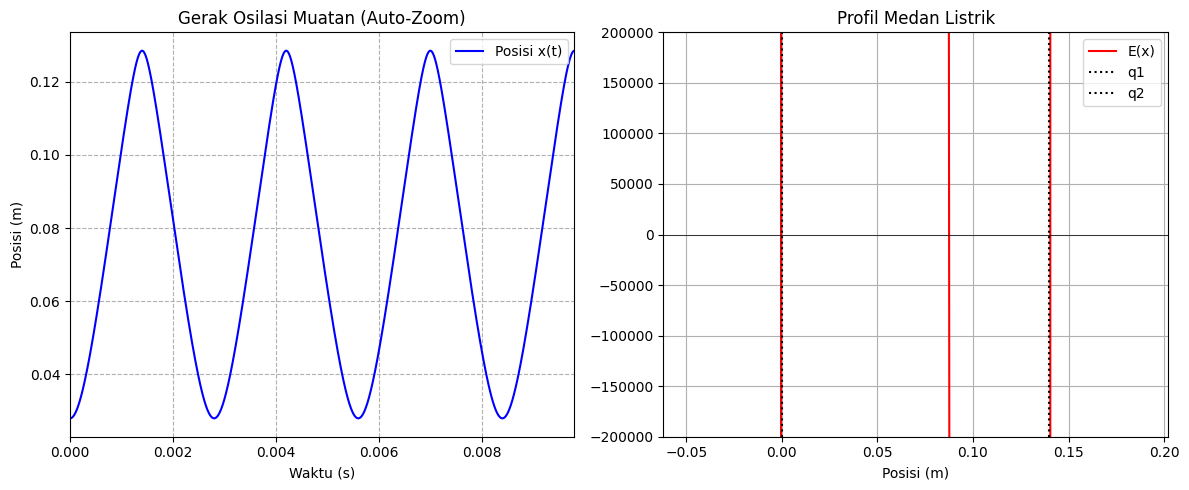

In [ ]:
# --- REVISI TOPIK 1: AUTO-ZOOM & DIAGNOSTIK ---
from scipy.signal import find_peaks

# 1. SETUP PARAMETER (Sama seperti sebelumnya)
q1 = (p1 + 1) * 1e-6
sign_q2 = (-1)**(A % 2)
q2 = sign_q2 * ((p2 % 10) + 1) * 1e-6
L = 0.1 + 0.01 * (A % 10)

# Parameter Fisika
k_c = 8.99e9
q0  = 1e-9
m   = 1e-6
eps = 1e-9

print(f"--- Diagnostik Topik 1 ---")
print(f"Muatan q1={q1:.2e}, q2={q2:.2e}, Jarak L={L:.3f}")

# 2. FUNGSI FISIKA
def calc_E(x):
    r1 = x - 0
    r2 = x - L
    dist1 = np.where(np.abs(r1) < eps, eps, np.abs(r1))
    dist2 = np.where(np.abs(r2) < eps, eps, np.abs(r2))
    return k_c*q1/(dist1**2)*np.sign(r1) + k_c*q2/(dist2**2)*np.sign(r2)

def model_gerak(t, y):
    x = y[0]
    v = y[1]
    # Batasi agar tidak keluar jalur (opsional, untuk keamanan numerik)
    if x < 0 or x > L:
        a = 0 # Jika nabrak dinding muatan, berhenti (teoretis tidak mungkin krn gaya tolak)
    else:
        a = (q0 * calc_E(x)) / m
    return [v, a]

# 3. SIMULASI DENGAN STEP SANGAT RAPAT
# Kita pakai durasi pendek saja cukup untuk melihat pola (0.1 detik)
# Tapi dengan resolusi tinggi (1e-6 detik)
t_final_sim = 0.1
max_step_sim = 1e-6

x0_start = 0.2 * L
y0 = [x0_start, 0.0]

print("Sedang menghitung simulasi... (mohon tunggu sebentar)")
sol = solve_ivp(model_gerak, (0, t_final_sim), y0, max_step=max_step_sim, method='RK45')

# 4. AUTO-ZOOM PINTAR
# Cari puncak-puncak gelombang (lokasi partikel terjauh)
peaks, _ = find_peaks(sol.y[0])
valleys, _ = find_peaks(-sol.y[0])

# Jika ada gelombang terdeteksi, kita zoom ke 3 gelombang pertama
if len(peaks) > 3:
    end_index = peaks[3] # Ambil indeks puncak ke-4
    t_zoom = sol.t[end_index]
    print(f"Gelombang terdeteksi! Zooming ke t = 0 s.d {t_zoom:.5f} s")
else:
    # Jika tidak nemu puncak (gerak lambat), tampilkan semua
    t_zoom = t_final_sim
    print("Gelombang lambat/tidak terdeteksi, menampilkan default.")

# 5. PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# PLOT 1: Posisi x(t)
ax1.plot(sol.t, sol.y[0], 'b-', linewidth=1.5, label='Posisi x(t)')
ax1.set_title('Gerak Osilasi Muatan (Auto-Zoom)')
ax1.set_xlabel('Waktu (s)')
ax1.set_ylabel('Posisi (m)')
ax1.set_xlim(0, t_zoom) # <--- INI KUNCINYA
ax1.grid(True, which='both', linestyle='--')
ax1.legend()

# PLOT 2: Medan E(x)
x_dom = np.linspace(-0.05, L+0.05, 500)
E_dom = calc_E(x_dom)
ax2.plot(x_dom, E_dom, 'r-', label='E(x)')
ax2.set_title('Profil Medan Listrik')
ax2.set_xlabel('Posisi (m)')
ax2.set_ylim(-2e5, 2e5) # Batasi Y agar garis nol terlihat
ax2.axvline(0, color='k', ls=':', label='q1')
ax2.axvline(L, color='k', ls=':', label='q2')
ax2.axhline(0, color='k', lw=0.5)
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


RUNNING TOPIK 2: POTENSIAL 3 MUATAN
Jarak a = 0.060 m
Muatan: qA=2.90e-06 C, qB=5.00e-07 C


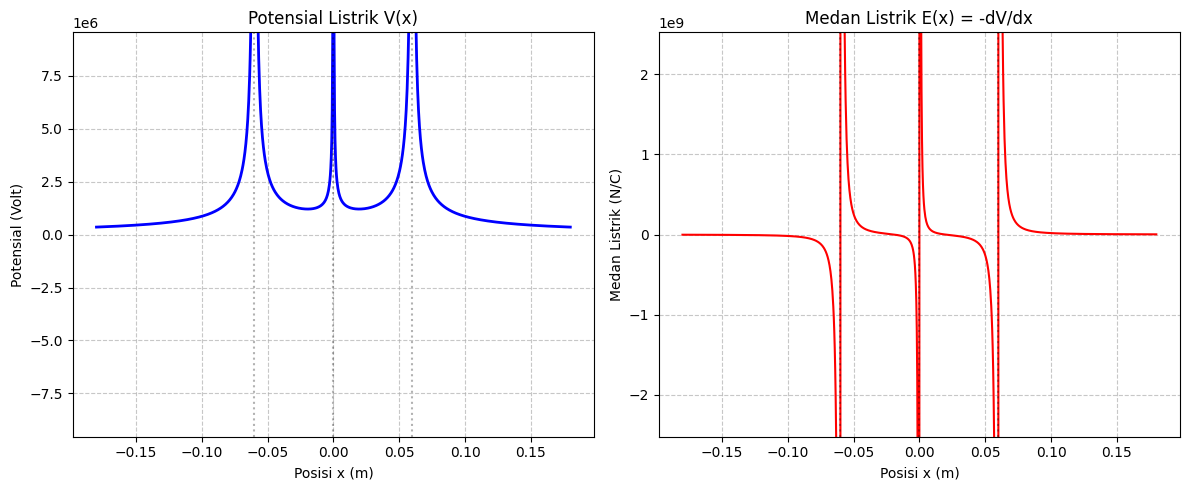

In [ ]:
# Konstanta Umum
k_c = 8.99e9       # Konstanta Coulomb
eps0 = 8.85e-12    # Permitivitas vakum
mu0 = 4 * np.pi * 1e-7  # Permeabilitas vakum

# ------------------------------------------------------------------------------
# TOPIK 2: POTENSIAL & SUPERPOSISI (3 MUATAN)
# Referensi: PDF Halaman 4
# ------------------------------------------------------------------------------
print("\n" + "="*40)
print("RUNNING TOPIK 2: POTENSIAL 3 MUATAN")
print("="*40)

# [cite_start]1. Parameter [cite: 83-85]
a_t2 = 0.02 + 0.01 * (A % 10)
qA = ((p2 % 50) + 1) * 1e-7
qB_sign = (-1)**(B % 2)
qB = qB_sign * ((p1 % 10) + 1) * 1e-7

# Posisi muatan: -a (qA), 0 (qB), +a (qA) -> Konfigurasi Simetris Umum
pos_charges = np.array([-a_t2, 0, a_t2])
val_charges = np.array([qA, qB, qA])

print(f"Jarak a = {a_t2:.3f} m")
print(f"Muatan: qA={qA:.2e} C, qB={qB:.2e} C")

# 2. Perhitungan Numerik
# Kita buat grid sangat rapat untuk hasil mulus
x_t2 = np.linspace(-3*a_t2, 3*a_t2, 1000)
V_t2 = np.zeros_like(x_t2)

# Hitung V Total (Superposisi)
for q, x_q in zip(val_charges, pos_charges):
    r = np.abs(x_t2 - x_q)
    # Proteksi singularitas: jika r < 1e-9, anggap 1e-9
    r = np.where(r < 1e-9, 1e-9, r)
    V_t2 += k_c * q / r

# Hitung Medan Listrik E = -dV/dx secara numerik
# np.gradient menghitung selisih pusat (central difference)
dx = x_t2[1] - x_t2[0]
E_t2 = -np.gradient(V_t2, dx)

# 3. Plotting
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Potensial V
ax1.plot(x_t2, V_t2, 'b-', linewidth=2)
ax1.set_title('Potensial Listrik V(x)')
ax1.set_xlabel('Posisi x (m)')
ax1.set_ylabel('Potensial (Volt)')
ax1.grid(True, linestyle='--', alpha=0.7)
# Potong sumbu Y agar singularitas tidak merusak skala
v_limit = np.percentile(np.abs(V_t2), 95)
ax1.set_ylim(-v_limit*1.5, v_limit*1.5)

# Plot Medan E
ax2.plot(x_t2, E_t2, 'r-', linewidth=1.5)
ax2.set_title('Medan Listrik E(x) = -dV/dx')
ax2.set_xlabel('Posisi x (m)')
ax2.set_ylabel('Medan Listrik (N/C)')
ax2.grid(True, linestyle='--', alpha=0.7)
# Potong sumbu Y
e_limit = np.percentile(np.abs(E_t2), 95)
ax2.set_ylim(-e_limit*1.5, e_limit*1.5)

# Tandai lokasi muatan
for p in pos_charges:
    ax1.axvline(p, color='k', linestyle=':', alpha=0.3)
    ax2.axvline(p, color='k', linestyle=':', alpha=0.3)

plt.tight_layout()
plt.show()



RUNNING TOPIK 3: HUKUM GAUSS
Kasus: Sfera (Bola Bermuatan)
Q=2.48e-05 C, R=0.040 m, eps_r=1.3


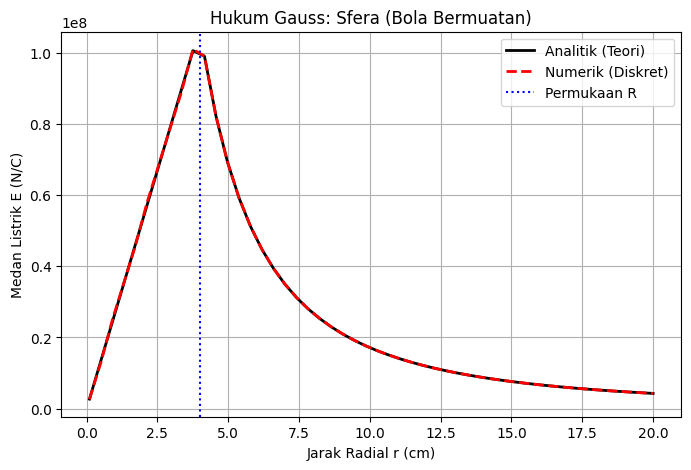

In [ ]:
# ------------------------------------------------------------------------------
# TOPIK 3: HUKUM GAUSS (SFERA / SILINDER)
# Referensi: PDF Halaman 4
# ------------------------------------------------------------------------------
print("\n" + "="*40)
print("RUNNING TOPIK 3: HUKUM GAUSS")
print("="*40)

# [cite_start]1. Cek Kasus (Ganjil/Genap A) [cite: 92-93]
is_sphere = (A % 2 == 0)
r_domain = np.linspace(0.001, 0.20, 50) # 0 sd 20 cm
E_analitik = np.zeros_like(r_domain)
E_numerik = np.zeros_like(r_domain)

if is_sphere:
    case_name = "Sfera (Bola Bermuatan)"
    # [cite_start]Parameter Sfera [cite: 94]
    Q_sph = (p1 + (p2 % 100)/100.0) * 1e-6
    R_sph = 0.02 + 0.005 * (A % 5)
    eps_r = 1 + 0.1 * (B % 9)
    eps_mat = eps0 * eps_r

    print(f"Kasus: {case_name}")
    print(f"Q={Q_sph:.2e} C, R={R_sph:.3f} m, eps_r={eps_r:.1f}")

    # A. Analitik (Hukum Gauss untuk Bola Isolator Uniform)
    # r < R: E ~ r
    # r > R: E ~ 1/r^2
    for i, r in enumerate(r_domain):
        if r < R_sph:
            E_analitik[i] = (Q_sph * r) / (4 * np.pi * eps_mat * R_sph**3)
        else:
            E_analitik[i] = Q_sph / (4 * np.pi * eps_mat * r**2)

    # B. Numerik (Metode Kulit Bola/Shells)
    # Bola dibagi menjadi banyak kulit tipis
    N_shells = 200
    dr = R_sph / N_shells
    shell_radii = np.linspace(dr/2, R_sph-dr/2, N_shells)
    # Muatan per shell (dQ = rho * 4pi r^2 dr)
    # Karena uniform, dQ sebanding dengan volume shell
    vol_total = (4/3) * np.pi * R_sph**3
    rho = Q_sph / vol_total

    for i, r_obs in enumerate(r_domain):
        E_sum = 0
        for r_s in shell_radii:
            # Volume shell tipis = 4 * pi * r^2 * dr
            dV = 4 * np.pi * (r_s**2) * dr
            dq = rho * dV

            # Jika titik ukur di luar shell -> shell dianggap muatan titik
            if r_obs > r_s:
                dE = dq / (4 * np.pi * eps_mat * r_obs**2)
                E_sum += dE
            # Jika titik ukur di dalam shell -> E = 0 (Shell Theorem)
        E_numerik[i] = E_sum

else:
    case_name = "Silinder (Kawat Panjang)"
    # [cite_start]Parameter Silinder [cite: 95]
    lam_cyl = (p1/100.0 + (B % 10)/10.0) * 1e-6
    Leff = 1.0 + 0.1 * (A % 5)

    print(f"Kasus: {case_name}")
    print(f"Lambda={lam_cyl:.2e} C/m, Panjang Efektif={Leff:.2f} m")

    # A. Analitik (Gauss untuk Kawat Tak Hingga)
    # E = lambda / (2 pi eps0 r)
    E_analitik = lam_cyl / (2 * np.pi * eps0 * r_domain)

    # B. Numerik (Diskretisasi Segmen Garis)
    # Kawat dibagi menjadi N potongan kecil
    N_seg = 200
    z_segments = np.linspace(-Leff/2, Leff/2, N_seg)
    dz = Leff / N_seg
    dq = lam_cyl * dz

    # Hitung E di bidang tengah (z=0) pada jarak r
    for i, r_obs in enumerate(r_domain):
        E_vec_sum = 0
        for z in z_segments:
            # Jarak miring dari elemen dq ke titik ukur
            dist = np.sqrt(r_obs**2 + z**2)
            # Medan listrik dE (magnitude)
            dE = dq / (4 * np.pi * eps0 * dist**2)
            # Ambil komponen radial saja (cos theta = r / dist)
            # Komponen z saling meniadakan karena simetri
            dE_rad = dE * (r_obs / dist)
            E_vec_sum += dE_rad
        E_numerik[i] = E_vec_sum

# Plot Topik 3
plt.figure(figsize=(8, 5))
plt.plot(r_domain*100, E_analitik, 'k-', linewidth=2, label='Analitik (Teori)')
plt.plot(r_domain*100, E_numerik, 'r--', linewidth=2, label='Numerik (Diskret)')
plt.title(f'Hukum Gauss: {case_name}')
plt.xlabel('Jarak Radial r (cm)')
plt.ylabel('Medan Listrik E (N/C)')
if is_sphere:
    plt.axvline(R_sph*100, color='blue', linestyle=':', label='Permukaan R')
plt.legend()
plt.grid(True)
plt.show()




RUNNING TOPIK 4: KAPASITOR PELAT SEJAJAR
Area=0.0140 m^2, d_total=1.80 mm
Dielektrik 1 (er=6) & Dielektrik 2 (er=4)
Hasil: C_total = 3.30e-10 F
       V_total = 15133.17 V


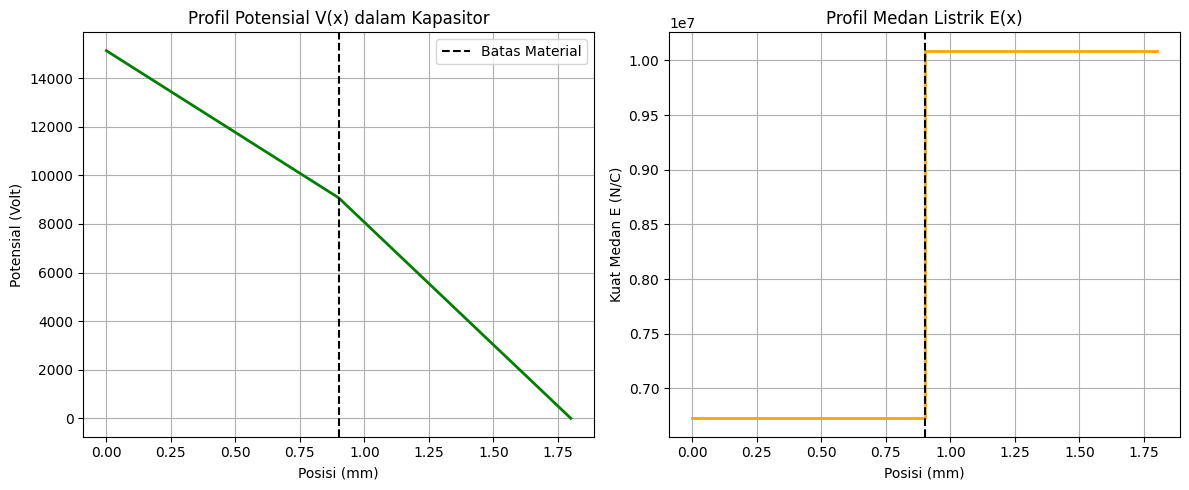

In [ ]:
# ------------------------------------------------------------------------------
# TOPIK 4: DIELEKTRIK & KAPASITANSI
# Referensi: PDF Halaman 5
# ------------------------------------------------------------------------------
print("\n" + "="*40)
print("RUNNING TOPIK 4: KAPASITOR PELAT SEJAJAR")
print("="*40)

# [cite_start]1. Parameter [cite: 106-109]
A_plate = 0.01 + 0.001 * (A % 10)
d_total = 1e-3 + 1e-4 * (p2 % 10)
er1 = 2 + (A % 5)
er2 = 1 + (B % 5)
if er1 == er2: er2 += 1  # Syarat tugas jika sama
Q_cap = ((p1 % 20) + 1) * 1e-6

# Bagi dua lapisan sama tebal
d1 = d_total / 2
d2 = d_total / 2

print(f"Area={A_plate:.4f} m^2, d_total={d_total*1000:.2f} mm")
print(f"Dielektrik 1 (er={er1}) & Dielektrik 2 (er={er2})")

# 2. Perhitungan Fisika
# Kapasitansi Seri: 1/Ceq = 1/C1 + 1/C2
C1 = (eps0 * er1 * A_plate) / d1
C2 = (eps0 * er2 * A_plate) / d2
C_eq = 1 / (1/C1 + 1/C2)
V_total = Q_cap / C_eq

# Medan Listrik di masing-masing lapisan (Gauss di dielektrik)
# E = Q / (eps * A)
E1 = Q_cap / (eps0 * er1 * A_plate)
E2 = Q_cap / (eps0 * er2 * A_plate)

# 3. Profil Potensial V(x)
x_cap = np.linspace(0, d_total, 200)
V_cap = np.zeros_like(x_cap)
E_profile = np.zeros_like(x_cap)

# Hitung potensial di setiap titik (integrasi E)
# V(x) = V_total - integral(E dl)
for i, x in enumerate(x_cap):
    if x <= d1:
        # Di lapisan 1
        V_cap[i] = V_total - E1 * x
        E_profile[i] = E1
    else:
        # Di lapisan 2
        V_batas = V_total - E1 * d1
        V_cap[i] = V_batas - E2 * (x - d1)
        E_profile[i] = E2

print(f"Hasil: C_total = {C_eq:.2e} F")
print(f"       V_total = {V_total:.2f} V")

# 4. Plotting
fig4, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Potensial
ax1.plot(x_cap*1000, V_cap, 'g-', linewidth=2)
ax1.set_title('Profil Potensial V(x) dalam Kapasitor')
ax1.set_xlabel('Posisi (mm)')
ax1.set_ylabel('Potensial (Volt)')
ax1.axvline(d1*1000, color='k', linestyle='--', label='Batas Material')
ax1.grid(True)
ax1.legend()

# Plot Medan Listrik (Step Function)
ax2.step(x_cap*1000, E_profile, color='orange', where='mid', linewidth=2)
ax2.set_title('Profil Medan Listrik E(x)')
ax2.set_xlabel('Posisi (mm)')
ax2.set_ylabel('Kuat Medan E (N/C)')
ax2.axvline(d1*1000, color='k', linestyle='--', label='Batas Material')
ax2.grid(True)

plt.tight_layout()
plt.show()




RUNNING TOPIK 5: MEDAN MAGNET LOOP ARUS
Radius R=1.40 cm, Arus I=1.80 A
Diskretisasi loop menjadi 144 segmen


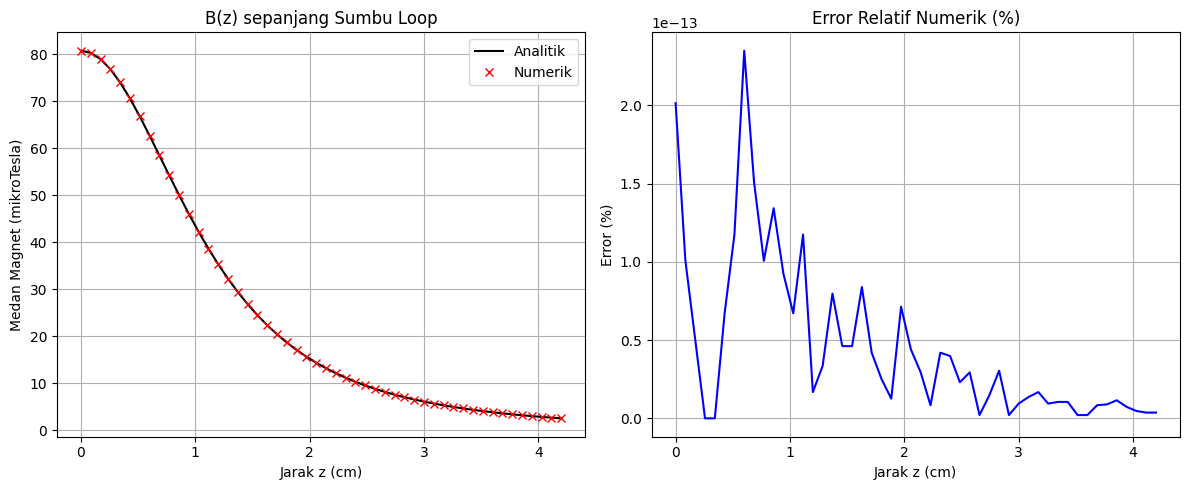

In [ ]:
# ------------------------------------------------------------------------------
# TOPIK 5: MEDAN MAGNET (HUKUM BIOT-SAVART)
# Referensi: PDF Halaman 5
# ------------------------------------------------------------------------------
print("\n" + "="*40)
print("RUNNING TOPIK 5: MEDAN MAGNET LOOP ARUS")
print("="*40)

# [cite_start]1. Parameter [cite: 118-120]
R_loop = 0.01 + 0.001 * (A % 10)
I_loop = 1.0 + (p2 % 10) / 10.0
N_seg = 72 + (A % 5) * 18  # Jumlah segmen diskret

print(f"Radius R={R_loop*100:.2f} cm, Arus I={I_loop:.2f} A")
print(f"Diskretisasi loop menjadi {N_seg} segmen")

# 2. Setup Loop & Sumbu Z
z_vals = np.linspace(0, 3*R_loop, 50)
B_analitik = np.zeros_like(z_vals)
B_numerik = np.zeros_like(z_vals)

# A. Analitik (Rumus Jadi Sumbu Loop)
# B = (mu0 I R^2) / 2(R^2 + z^2)^1.5
B_analitik = (mu0 * I_loop * R_loop**2) / (2 * (R_loop**2 + z_vals**2)**(1.5))

# B. Numerik (Biot-Savart Integral)
# Koordinat segmen loop (lingkaran di bidang xy)
theta = np.linspace(0, 2*np.pi, N_seg, endpoint=False)
dl_scalar = (2 * np.pi * R_loop) / N_seg

# Posisi elemen arus (x,y,0)
x_seg = R_loop * np.cos(theta)
y_seg = R_loop * np.sin(theta)

# Vektor arah arus dl (-sin, cos, 0)
dl_x = -np.sin(theta) * dl_scalar
dl_y = np.cos(theta) * dl_scalar
# dl_z = 0

for i, z_p in enumerate(z_vals):
    Bz_total = 0
    # Loop unuk setiap segmen kawat
    for j in range(N_seg):
        # Vektor r dari segmen ke titik P(0,0,z)
        # r_vec = P - Segmen = (0-x, 0-y, z-0)
        rx = -x_seg[j]
        ry = -y_seg[j]
        rz = z_p
        dist = np.sqrt(rx**2 + ry**2 + rz**2)

        # Cross Product (dl x r)
        # Kita hanya butuh komponen Z untuk dibandingkan
        # (dl x r)_z = dl_x * ry - dl_y * rx
        cross_z = dl_x[j]*ry - dl_y[j]*rx

        # Rumus Biot Savart: dB = (mu0 I / 4pi) * (dl x r) / r^3
        dBz = (mu0 * I_loop / (4 * np.pi)) * cross_z / (dist**3)
        Bz_total += dBz

    B_numerik[i] = Bz_total

# Hitung Error Relatif (%)
error_rel = np.abs(B_numerik - B_analitik) / np.max(B_analitik) * 100

# 3. Plotting
fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Perbandingan
ax1.plot(z_vals*100, B_analitik*1e6, 'k-', label='Analitik')
ax1.plot(z_vals*100, B_numerik*1e6, 'rx', label='Numerik')
ax1.set_title('B(z) sepanjang Sumbu Loop')
ax1.set_xlabel('Jarak z (cm)')
ax1.set_ylabel('Medan Magnet (mikroTesla)')
ax1.legend()
ax1.grid(True)

# Plot Error
ax2.plot(z_vals*100, error_rel, 'b-')
ax2.set_title('Error Relatif Numerik (%)')
ax2.set_xlabel('Jarak z (cm)')
ax2.set_ylabel('Error (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()